In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
from torchsummary import summary
import os
from sklearn.model_selection import train_test_split
from torch.autograd import Variable


%matplotlib inline

In [2]:
X, y = np.load('./drive/My Drive/mri_data/tensors.npy'), np.load('./drive/My Drive/mri_data/labels.npy')
X = X[:, np.newaxis, :, :, :]
print(X.shape, y.shape)

(517, 1, 58, 70, 58) (517,)


In [0]:
class MriData(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(MriData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y).long()
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) #may be that's bad idea to split using train_test_split. Instead of it - use indexes of data
del X, y #deleting for freeing space on disc

train_dataset = MriData(X_train, y_train)
test_dataset = MriData(X_test, y_test)
del X_train, X_test, y_train, y_test #deleting for freeing space on disc


In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=46, shuffle=True)  #46 - recommended empirical value for batchsize
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=28, shuffle=False) 

In [0]:
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
hidden = lambda c_in, c_out: nn.Sequential(
    nn.Conv3d(c_in, c_out, (3,3,3)),
    nn.BatchNorm3d(c_out),
    nn.ReLU(),
    nn.MaxPool3d(2)
)

class MriNet(nn.Module):
    def __init__(self, c):
        super(MriNet, self).__init__()
        self.hidden1 = hidden(1, c)
        self.hidden2 = hidden(c, 2*c)
        self.hidden3 = hidden(2*c, 4*c)
        self.linear = nn.Linear(128*5*7*5, 2)
        self.flatten = nn.Flatten()
        self.drop_layer = nn.Dropout(p=.5) #dropout for preventing overfitting

    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = F.log_softmax(x, dim=1)
        x = self.drop_layer(x) 
        return x

c = 32
model = MriNet(c).to(device)
summary(model, (1, 58, 70, 58))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 56, 68, 56]             896
       BatchNorm3d-2       [-1, 32, 56, 68, 56]              64
              ReLU-3       [-1, 32, 56, 68, 56]               0
         MaxPool3d-4       [-1, 32, 28, 34, 28]               0
            Conv3d-5       [-1, 64, 26, 32, 26]          55,360
       BatchNorm3d-6       [-1, 64, 26, 32, 26]             128
              ReLU-7       [-1, 64, 26, 32, 26]               0
         MaxPool3d-8       [-1, 64, 13, 16, 13]               0
            Conv3d-9      [-1, 128, 11, 14, 11]         221,312
      BatchNorm3d-10      [-1, 128, 11, 14, 11]             256
             ReLU-11      [-1, 128, 11, 14, 11]               0
        MaxPool3d-12         [-1, 128, 5, 7, 5]               0
          Flatten-13                [-1, 22400]               0
           Linear-14                   

In [0]:
CHECKPOINTS_DIR =  './drive/My Drive/mri_data/checkpoints/'

criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)

In [0]:
def get_accuracy(net, data_loader):
    net.eval()
    correct = 0
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        del data, target
    accuracy = 100. * correct / len(data_loader.dataset)
    return accuracy.item()

def train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler=None, verbose=True, save=False):
    best_val_loss = 100_000
    best_model = None
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        train_loss = 0
        for X, y in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = net(X)
            loss = criterion(out, y)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            del X, y #freeing gpu space
            
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        net.eval()
        val_loss = 0
        for X, y in val_loader:
            # Compute the validation loss
            X, y = X.to(device), y.to(device)
            out = net(X)
            val_loss += criterion(out, y).item()
            del X, y #freeing gpu space
         
        if scheduler is not None:
            scheduler.step(train_loss)
        
        
        train_loss_list.append(train_loss/len(train_loader))
        val_loss_list.append(val_loss/len(val_loader))
        train_acc_list.append(get_accuracy(net, train_loader))
        val_acc_list.append(get_accuracy(net, val_loader))

        if save and val_loss_list[-1] < best_val_loss:
            torch.save(net.state_dict(), CHECKPOINTS_DIR+'best_model')
        freq = 1
        if verbose and epoch%freq==0:
            print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, train_loss/len(train_loader), val_loss/len(val_loader)))
        
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list
            
            

In [13]:
torch.manual_seed(2)
EPOCHS = 20

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=True) 

Epoch 01/20 || Loss:  Train 3.2159 | Validation 3.9734
Epoch 02/20 || Loss:  Train 1.0603 | Validation 1.8240
Epoch 03/20 || Loss:  Train 3.5227 | Validation 0.6701
Epoch 04/20 || Loss:  Train 1.3112 | Validation 1.0609
Epoch 05/20 || Loss:  Train 0.8331 | Validation 1.0445
Epoch 06/20 || Loss:  Train 2.3475 | Validation 0.7507
Epoch 07/20 || Loss:  Train 0.5865 | Validation 0.7022
Epoch 08/20 || Loss:  Train 0.5053 | Validation 0.4984
Epoch 09/20 || Loss:  Train 0.3478 | Validation 0.4106
Epoch 10/20 || Loss:  Train 0.2617 | Validation 0.3563
Epoch 11/20 || Loss:  Train 0.2359 | Validation 0.3625
Epoch 12/20 || Loss:  Train 0.3111 | Validation 0.3221
Epoch 13/20 || Loss:  Train 0.2529 | Validation 0.3386
Epoch 14/20 || Loss:  Train 0.2640 | Validation 0.3292
Epoch 15/20 || Loss:  Train 0.2276 | Validation 0.3157
Epoch 16/20 || Loss:  Train 0.1915 | Validation 0.3420
Epoch 17/20 || Loss:  Train 0.2349 | Validation 0.3354
Epoch 18/20 || Loss:  Train 0.2340 | Validation 0.2933
Epoch 19/2

In [0]:
PATH_TO_SAVE_MODEL = './drive/My Drive/mri_data/final_mri_model'
torch.save(model.state_dict(), PATH_TO_SAVE_MODEL)

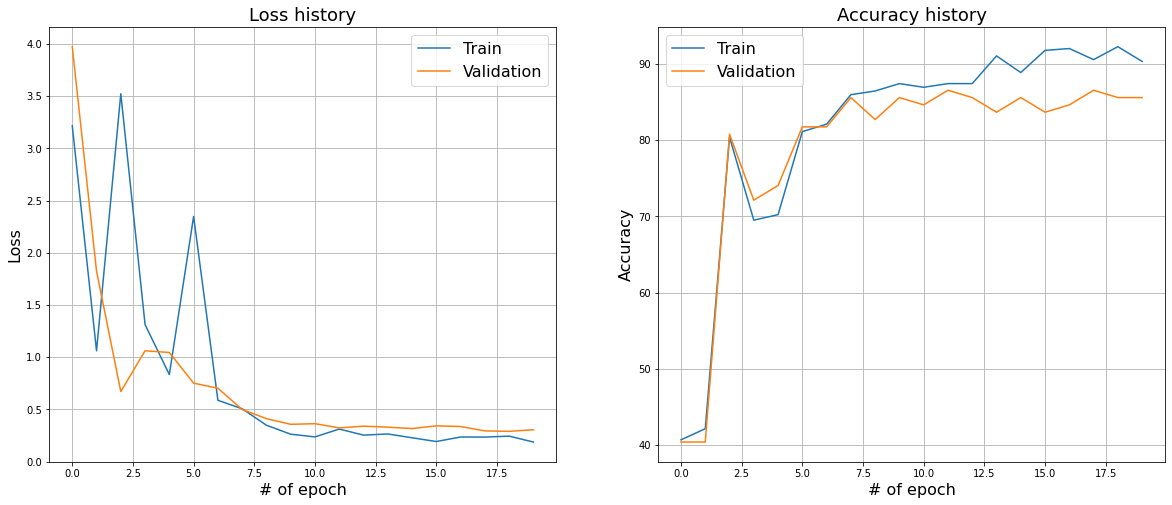

In [15]:
plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
plt.title('Loss history', fontsize=18)
plt.plot(train_loss_list, label='Train')
plt.plot(val_loss_list, label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Accuracy history', fontsize=18)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=16)
plt.grid()





